<a href="https://colab.research.google.com/github/lbolsinger/perimeter_institute/blob/main/modelling_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
## imports

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import semopy
import numpy as np
from scipy.optimize import minimize
import graphviz
import lingam
from lingam.utils import make_dot
import semopy
from dowhy import CausalModel
from dowhy import gcm
import networkx as nx
from dowhy.gcm import AdditiveNoiseModel
from dowhy.gcm.ml import create_linear_regressor
from scipy.stats import norm
import pymc as pm
import arviz as az
import graphviz as gr
from pymc import Model, HalfCauchy, Normal, sample

In [5]:
## data

df = pd.read_csv("og.csv")
# marital_status: 1=married, 0=single
# sex: 1=f, 0=m
continuous_cols = ['age', 'accidents', 'income', 'premium', 'adjusted_premium']
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
df.drop(columns=['Unnamed: 0'], inplace=True)
df.to_csv("scaled.csv")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[632 547]
 [480 741]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55      1179
           1       0.58      0.61      0.59      1221

    accuracy                           0.57      2400
   macro avg       0.57      0.57      0.57      2400
weighted avg       0.57      0.57      0.57      2400


Model Coefficients:
            Feature  Coefficient
0              year    -0.000011
1               age     0.192505
2    marital_status     0.080953
3               sex     0.072486
4            income     0.105368
5  adjusted_premium    -0.008620
6           premium    -0.172013
7         treatment     0.018680
8         accidents     0.160735

Model Intercept:
-0.00014837416973604675 



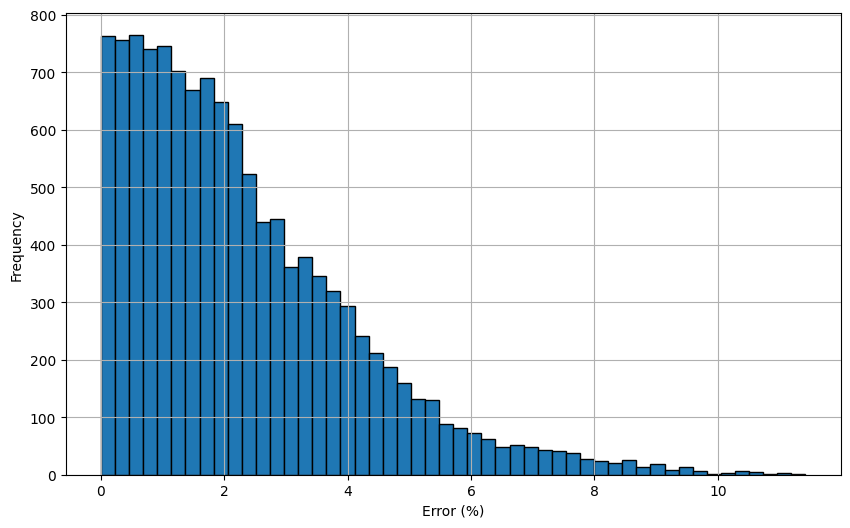

In [6]:
## sklearn logistic regression

df_scaled = pd.read_csv("scaled.csv")

y = df_scaled['retained']
X = df_scaled[['year', 'age', 'marital_status', 'sex', 'income', 'adjusted_premium', 'premium', 'treatment', 'accidents']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nModel Coefficients:")
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print(coefficients)

print("\nModel Intercept:")
print(model.intercept_[0], "\n")

predicted_prob = model.predict_proba(X)[:, 1]
df_scaled['predicted_prob'] = predicted_prob
df_scaled.to_csv("prediction_sklearn.csv", index=False)

df_scaled['predicted_error'] = abs(df_scaled['predicted_prob'] - df_scaled['retained'])
df_scaled['noise_error'] = abs(df_scaled['retention_noise'] - df_scaled['retained'])

error = 100*abs(df_scaled['predicted_prob'] - df_scaled['retention_noise'])/df_scaled['retention_noise']
plt.figure(figsize=(10, 6))
plt.hist(error, bins=50, edgecolor='black')
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [3]:
%pip install semopy

In [7]:
### semopy with DAG in mind

desc = '''
marital_status ~ age
premium ~ age + marital_status + sex + accidents + income
adjusted_premium ~ premium + treatment
retained ~ year + premium + adjusted_premium + treatment + age + marital_status + sex + accidents + income

marital_status ~~ marital_status
retained ~~ retained
'''

df = pd.read_csv("scaled.csv")

model = semopy.Model(desc)
model.fit(df)
print(model.inspect())
g = semopy.semplot(model, "with_DAG_semopy.png")



                lval  op              rval  Estimate  Std. Err      z-value  \
0     marital_status   ~               age  0.305077  0.003498    87.207045   
1            premium   ~               age -0.268626  0.005639   -47.633283   
2            premium   ~    marital_status -0.576476  0.011513   -50.072228   
3            premium   ~               sex -0.604483  0.008824   -68.500885   
4            premium   ~         accidents  0.649928  0.004412   147.302537   
5            premium   ~            income  0.099112  0.004412    22.463665   
6   adjusted_premium   ~           premium  0.734193  0.000680  1079.628763   
7   adjusted_premium   ~         treatment  6.074908  0.006090   997.499999   
8           retained   ~              year  0.001993  0.002634     0.756373   
9           retained   ~           premium -0.051250  0.045223    -1.133280   
10          retained   ~  adjusted_premium -0.004255  0.060277    -0.070589   
11          retained   ~         treatment  0.002467

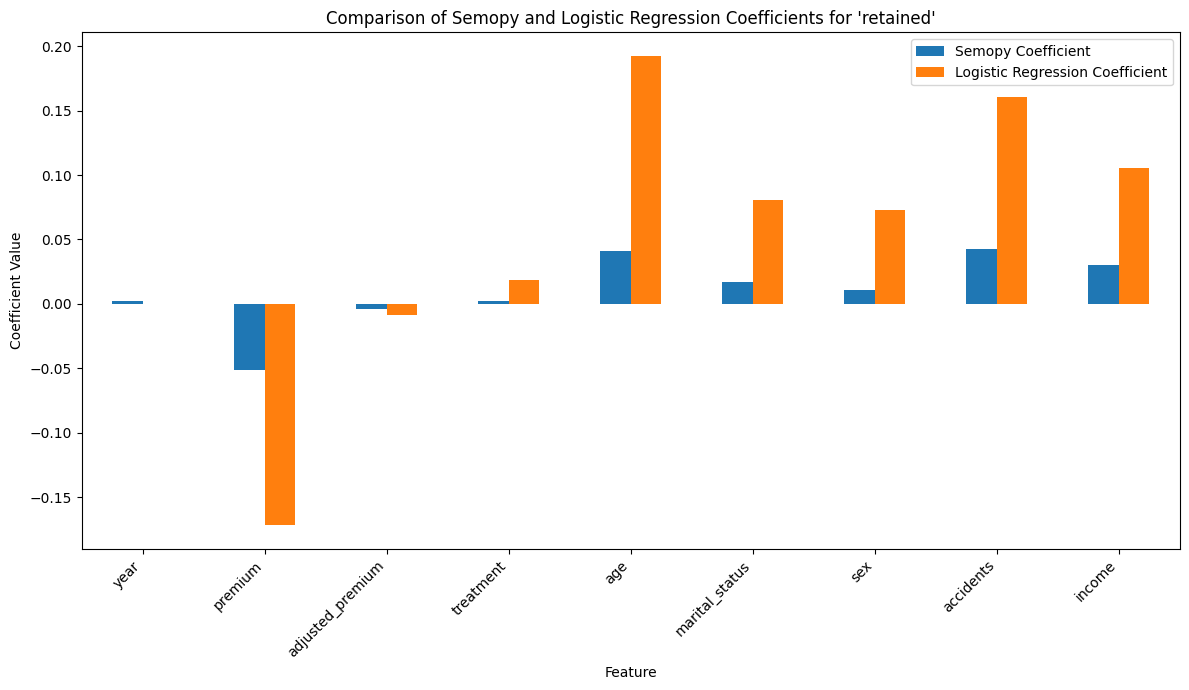

In [8]:
semopy_retained_coefficients = model.inspect()[model.inspect()['lval'] == 'retained']

semopy_retained_coefficients = semopy_retained_coefficients.rename(columns={'rval': 'Feature'})
semopy_retained_coefficients_selected = semopy_retained_coefficients[['Feature', 'Estimate']].rename(columns={'Estimate': 'Semopy Coefficient'})

coefficients_selected = coefficients[['Feature', 'Coefficient']].rename(columns={'Coefficient': 'Logistic Regression Coefficient'})

combined_coefficients = pd.merge(semopy_retained_coefficients_selected, coefficients_selected, on='Feature')

combined_coefficients = combined_coefficients.set_index('Feature')

combined_coefficients.plot(kind='bar', figsize=(12, 7))
plt.title("Comparison of Semopy and Logistic Regression Coefficients for 'retained'")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
## find a factor that minimizes the different between the coefficients of teh different methods

try:
    combined_coefficients
except NameError:
    print("The 'combined_coefficients' DataFrame is not available. Recreating it...")
    semopy_retained_coefficients = model.inspect()[model.inspect()['lval'] == 'retained']
    semopy_retained_coefficients = semopy_retained_coefficients[semopy_retained_coefficients['op'] == '~'].rename(columns={'rval': 'Feature'})
    semopy_retained_coefficients_selected = semopy_retained_coefficients[['Feature', 'Estimate']].rename(columns={'Estimate': 'Semopy Coefficient'})

    try:
        coefficients
    except NameError:
        print("The 'coefficients' DataFrame from Logistic Regression is not available. Please run the Logistic Regression cell first (cell 931b3bf5).")
        raise

    coefficients_selected = coefficients[['Feature', 'Coefficient']].rename(columns={'Coefficient': 'Logistic Regression Coefficient'})

    combined_coefficients = pd.merge(semopy_retained_coefficients_selected, coefficients_selected, on='Feature')

def objective_function(s, semopy_coeffs, lr_coeffs):
    scaled_semopy_coeffs = s * semopy_coeffs
    differences = scaled_semopy_coeffs - lr_coeffs
    sum_squared_differences = np.sum(differences**2)
    return sum_squared_differences

semopy_coeffs = combined_coefficients['Semopy Coefficient'].values
lr_coeffs = combined_coefficients['Logistic Regression Coefficient'].values

initial_scaling_factor = [1.0]

result = minimize(
    objective_function,
    initial_scaling_factor,
    args=(semopy_coeffs, lr_coeffs),
    method='L-BFGS-B',
    bounds=[(-100, 100)]
)

optimal_scaling_factor = result.x[0]

print(f"Optimal scaling factor to minimize the difference: {optimal_scaling_factor}")

scaled_semopy_coefficients = optimal_scaling_factor * combined_coefficients['Semopy Coefficient']
comparison_df = pd.DataFrame({
    'Feature': combined_coefficients.index,
    'Scaled Semopy Coefficient': scaled_semopy_coefficients,
    'Logistic Regression Coefficient': combined_coefficients['Logistic Regression Coefficient']
})
display(comparison_df.set_index('Feature'))

Optimal scaling factor to minimize the difference: 3.879605029988288


,Scaled Semopy Coefficient,Logistic Regression Coefficient
Feature,,
year,0.007730,-0.000011
premium,-0.198829,-0.172013
adjusted_premium,-0.016507,-0.008620
treatment,0.009571,0.018680
age,0.158924,0.192505
marital_status,0.067097,0.080953
sex,0.040341,0.072486
accidents,0.165072,0.160735
income,0.117402,0.105368


In [1]:
%pip install lingam

In [10]:
## semopy without known DAG

df = pd.read_csv("scaled.csv")
df.drop(columns=['Unnamed: 0', 'retention_prob', 'retention_noise', 'score'], inplace=True)

model = lingam.DirectLiNGAM()
model.fit(df)
labels = df.columns.tolist()
adj_matrix = model.adjacency_matrix_
g = make_dot(adj_matrix, labels=labels)

desc_lines = []
for i, target in enumerate(labels):
    parents = [labels[j] for j, coef in enumerate(adj_matrix[:, i]) if not np.isclose(coef, 0)]
    if parents:
        rhs = ' + '.join(parents)
        desc_lines.append(f"{target} ~ {rhs}")
desc = '\n'.join(desc_lines)

model = semopy.Model(desc)
model.fit(df)
#print(model.inspect())
g = semopy.semplot(model, "without_DAG_semopy_lingam.png")

In [2]:
%pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


In [11]:
## dowhy

df = pd.read_csv("scaled.csv")
df.drop(columns=['Unnamed: 0', 'retention_prob', 'retention_noise', 'score'], inplace=True)

causal_graph = nx.DiGraph([('age', 'marital_status'), ('age', 'premium'),
                           ('sex', 'premium'), ('marital_status', 'premium'),
                           ('accidents', 'premium'), ('income', 'premium'),
                           ('premium', 'adjusted_premium'), ('year', 'retained'),
                           ('treatment', 'adjusted_premium'), ('treatment', 'retained'),
                           ('adjusted_premium', 'retained'), ('age', 'retained'),
                           ('sex', 'retained'), ('accidents', 'retained'),
                           ('income', 'retained'), ('marital_status', 'retained')])

causal_model = gcm.ProbabilisticCausalModel(causal_graph)
for node in causal_graph.nodes:
    if list(causal_graph.predecessors(node)):
        causal_model.set_causal_mechanism(node,
                                          gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_linear_regressor(),
                                                                 noise_model=gcm.ScipyDistribution(norm)))
    else:
        causal_model.set_causal_mechanism(node, gcm.EmpiricalDistribution())

gcm.fit(causal_model, df)
strength = gcm.arrow_strength(causal_model, 'retained')
print("\nArrow strength:")
for s in strength:
    print(f"{s[0]}: {strength[s]}")

mechanism = causal_model.causal_mechanism('retained')
linear_model = mechanism.prediction_model

print("\nLinear Regression Coefficients: ")
parents = list(causal_graph.predecessors('retained'))
for parent, coef in zip(parents, linear_model.sklearn_model.coef_):
    print(f"{parent}: {coef}")
print(f"\nIntercept: {linear_model.sklearn_model.intercept_}")

Fitting causal mechanism of node treatment: 100%|██████████| 10/10 [00:00<00:00, 222.78it/s]



Arrow strength:
accidents: 0.0012373897458611528
adjusted_premium: 0.004241715134366997
age: 0.0013291036919474326
income: 0.0005038356814858195
marital_status: -0.00020309105974454617
sex: -0.00023888228773713798
treatment: 0.0014339750239024023
year: -0.00019455200605339465

Linear Regression Coefficients: 
year: 0.04090098943479652
treatment: -0.07093734279976091
adjusted_premium: 0.041463836589972186
age: 0.030358122700000476
sex: 0.018658191731273765
accidents: 0.011697945550944297
income: 0.40698153020695754
marital_status: 0.0022470959051209575

Intercept: -4.069617216909517


In [104]:
## pymc
df = pd.read_csv("scaled.csv")
df.drop(columns=['Unnamed: 0', 'retention_prob', 'retention_noise', 'score'], inplace=True)

y = df['retained']
x = df[['year', 'premium', 'adjusted_premium', 'age', 'sex', 'accidents', 'income', 'marital_status', 'treatment']]

y = y.values.astype(float)
x = x.values.astype(float)

with Model() as model:
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    likelihood = Normal("y", mu=intercept + np.dot(x, slope), sigma=20, observed=y)

    idata = sample(3000)

TypeError: Unsupported dtype for TensorType: object